In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import albumentations as albu
import segmentation_models as sm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
from model import ModelCreator
from datapipeline import DatasetCreator
import random
import shutil
tf.random.set_seed(1)
random.seed(1)

Segmentation Models: using `tf.keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
height = 512

In [4]:
val_transforms = albu.Compose([
    albu.Resize(height, height),
    albu.Lambda(image=lambda x,**kwargs: x/255),
])

/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1777: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn(


In [5]:
valdataset = DatasetCreator(val_transforms)

In [6]:
valdata = valdataset('crosval/val/*png','castom-masks/masks_machine/')
len(valdata)

8

In [7]:
trainaugmentation = albu.Compose([
    albu.Resize(int(height*1.5),int(height*1.5)),
    albu.RandomCrop(height, height,always_apply=True),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomRotate90(p=0.5),
    albu.Transpose(p=0.5),
    albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
    albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
    albu.GridDistortion(p=0.5),
    albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    albu.RandomBrightnessContrast(p=0.5),
    albu.RandomGamma(p=0.5),
    albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
    albu.GaussNoise(),
    albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
    albu.Lambda(image=lambda x,**kwargs: x/255),
    #albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],always_apply=True)
])#todo change later

In [8]:
traindataset = DatasetCreator(trainaugmentation)

In [9]:
traindata = traindataset('crosval/train/*png','castom-masks/masks_machine/')
len(traindata)

24

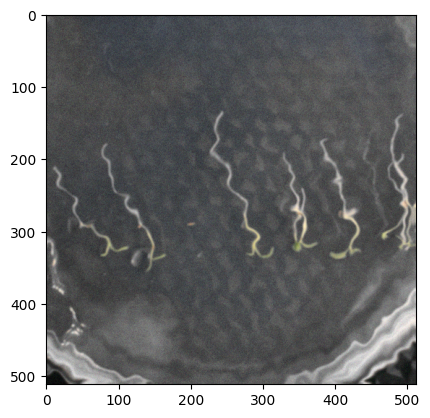

tf.Tensor(
[[[[0.33333334 0.33333334 0.35686275]
   [0.3372549  0.3254902  0.34117648]
   [0.30588236 0.34509805 0.30980393]
   ...
   [0.41960785 0.4117647  0.41960785]
   [0.44705883 0.43137255 0.4627451 ]
   [0.42745098 0.4509804  0.4509804 ]]

  [[0.29803923 0.30980393 0.3137255 ]
   [0.3019608  0.3529412  0.3137255 ]
   [0.29411766 0.32941177 0.30980393]
   ...
   [0.48235294 0.4627451  0.46666667]
   [0.45882353 0.47843137 0.45882353]
   [0.43529412 0.41960785 0.40784314]]

  [[0.33333334 0.34509805 0.30980393]
   [0.31764707 0.34117648 0.34117648]
   [0.32941177 0.29803923 0.3137255 ]
   ...
   [0.4509804  0.44313726 0.45882353]
   [0.42745098 0.41960785 0.42352942]
   [0.47058824 0.47058824 0.49019608]]

  ...

  [[0.05882353 0.04313726 0.0627451 ]
   [0.03137255 0.07058824 0.05490196]
   [0.04705882 0.05098039 0.05882353]
   ...
   [0.12941177 0.14117648 0.13333334]
   [0.15686275 0.15294118 0.14117648]
   [0.12156863 0.16078432 0.15294118]]

  [[0.07450981 0.07450981 0.074509

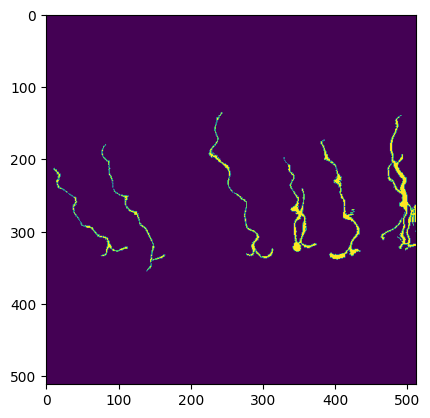

In [10]:
for image,mask in traindata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))
        print(image)

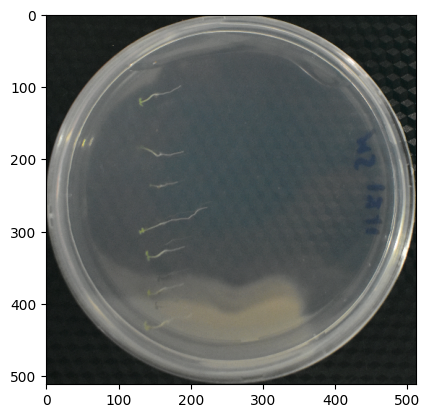

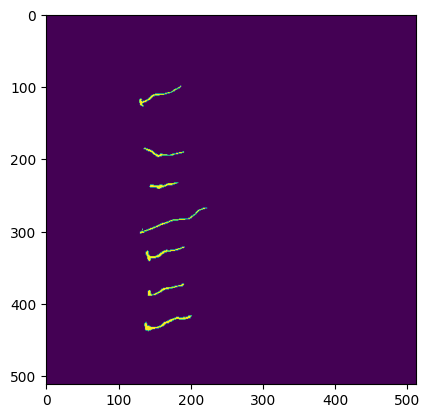

In [11]:
for image,mask in valdata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

In [12]:
modelcreator = ModelCreator()
model = modelcreator.buildmodel()
model.compile('Adam', loss=sm.losses.binary_focal_dice_loss, metrics=[sm.metrics.iou_score])

KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), name='conv2d_transpose_5/Sigmoid:0', description="created by layer 'conv2d_transpose_5'")


In [13]:
model.save('testovik.h5')

/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
#tf.keras.utils.plot_model(model)

In [15]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1) if epoch > 15 and epoch % 15 == 0 else lr

callback =[
    tf.keras.callbacks.EarlyStopping(min_delta=0.0001,patience=30,verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='bestmodel/',save_best_only=True,monitor='val_loss',verbose=1)
]

In [16]:
# fit model
model_history = model.fit(
    traindata,
    epochs=1000,
    validation_data=valdata,
    callbacks=callback,
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/1000
24/24 [==============================] - ETA: 0s - loss: 2.1868 - iou_score: 0.0273
Epoch 1: val_loss improved from inf to 7.21941, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 38s 1s/step - loss: 2.1868 - iou_score: 0.0273 - val_loss: 7.2194 - val_iou_score: 0.0163 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/1000
24/24 [==============================] - ETA: 0s - loss: 1.3089 - iou_score: 0.0221
Epoch 2: val_loss improved from 7.21941 to 5.33809, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 1.3089 - iou_score: 0.0221 - val_loss: 5.3381 - val_iou_score: 0.0156 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/1000
24/24 [==============================] - ETA: 0s - loss: 1.0983 - iou_score: 0.0346
Epoch 3: val_loss improved from 5.33809 to 3.30205, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 1.0983 - iou_score: 0.0346 - val_loss: 3.3021 - val_iou_score: 0.0181 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/1000
24/24 [==============================] - ETA: 0s - loss: 0.9808 - iou_score: 0.0536
Epoch 4: val_loss improved from 3.30205 to 1.28547, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.9808 - iou_score: 0.0536 - val_loss: 1.2855 - val_iou_score: 0.0246 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/1000
24/24 [==============================] - ETA: 0s - loss: 0.9002 - iou_score: 0.0864
Epoch 5: val_loss improved from 1.28547 to 0.95638, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.9002 - iou_score: 0.0864 - val_loss: 0.9564 - val_iou_score: 0.0310 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 6/1000
24/24 [==============================] - ETA: 0s - loss: 0.8195 - iou_score: 0.1393
Epoch 6: val_loss improved from 0.95638 to 0.95566, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.8195 - iou_score: 0.1393 - val_loss: 0.9557 - val_iou_score: 0.0431 - lr: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 7/1000
24/24 [==============================] - ETA: 0s - loss: 0.7992 - iou_score: 0.1498
Epoch 7: val_loss improved from 0.95566 to 0.90632, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.7992 - iou_score: 0.1498 - val_loss: 0.9063 - val_iou_score: 0.0565 - lr: 0.0010

Epoch 8: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 8/1000
24/24 [==============================] - ETA: 0s - loss: 0.7310 - iou_score: 0.1930
Epoch 8: val_loss did not improve from 0.90632
24/24 [==============================] - 34s 1s/step - loss: 0.7310 - iou_score: 0.1930 - val_loss: 0.9090 - val_iou_score: 0.0627 - lr: 0.0010

Epoch 9: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 9/1000
24/24 [==============================] - ETA: 0s - loss: 0.6704 - iou_score: 0.2306
Epoch 9: val_loss improved from 0.90632 to 0.90374, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.6704 - iou_score: 0.2306 - val_loss: 0.9037 - val_iou_score: 0.0690 - lr: 0.0010

Epoch 10: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 10/1000
24/24 [==============================] - ETA: 0s - loss: 0.6504 - iou_score: 0.2466
Epoch 10: val_loss improved from 0.90374 to 0.80838, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.6504 - iou_score: 0.2466 - val_loss: 0.8084 - val_iou_score: 0.1138 - lr: 0.0010

Epoch 11: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 11/1000
24/24 [==============================] - ETA: 0s - loss: 0.6723 - iou_score: 0.2328
Epoch 11: val_loss improved from 0.80838 to 0.80293, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.6723 - iou_score: 0.2328 - val_loss: 0.8029 - val_iou_score: 0.1274 - lr: 0.0010

Epoch 12: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 12/1000
24/24 [==============================] - ETA: 0s - loss: 0.6083 - iou_score: 0.2774
Epoch 12: val_loss improved from 0.80293 to 0.76157, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.6083 - iou_score: 0.2774 - val_loss: 0.7616 - val_iou_score: 0.1758 - lr: 0.0010

Epoch 13: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 13/1000
24/24 [==============================] - ETA: 0s - loss: 0.5841 - iou_score: 0.2984
Epoch 13: val_loss did not improve from 0.76157
24/24 [==============================] - 34s 1s/step - loss: 0.5841 - iou_score: 0.2984 - val_loss: 0.8001 - val_iou_score: 0.1239 - lr: 0.0010

Epoch 14: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 14/1000
24/24 [==============================] - ETA: 0s - loss: 0.5357 - iou_score: 0.3363
Epoch 14: val_loss did not improve from 0.76157
24/24 [==============================] - 33s 1s/step - loss: 0.5357 - iou_score: 0.3363 - val_loss: 0.7742 - val_iou_score: 0.1559 - lr: 0.0010

Epoch 15: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 15/1000
24/24 [============

INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.5356 - iou_score: 0.3384 - val_loss: 0.7489 - val_iou_score: 0.1608 - lr: 0.0010

Epoch 16: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 16/1000
24/24 [==============================] - ETA: 0s - loss: 0.5255 - iou_score: 0.3455
Epoch 16: val_loss improved from 0.74885 to 0.73881, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.5255 - iou_score: 0.3455 - val_loss: 0.7388 - val_iou_score: 0.1805 - lr: 0.0010

Epoch 17: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 17/1000
24/24 [==============================] - ETA: 0s - loss: 0.5499 - iou_score: 0.3283
Epoch 17: val_loss did not improve from 0.73881
24/24 [==============================] - 33s 1s/step - loss: 0.5499 - iou_score: 0.3283 - val_loss: 0.8692 - val_iou_score: 0.1077 - lr: 0.0010

Epoch 18: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 18/1000
24/24 [==============================] - ETA: 0s - loss: 0.5291 - iou_score: 0.3421 
Epoch 18: val_loss improved from 0.73881 to 0.70332, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 961s 41s/step - loss: 0.5291 - iou_score: 0.3421 - val_loss: 0.7033 - val_iou_score: 0.2027 - lr: 0.0010

Epoch 19: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 19/1000
24/24 [==============================] - ETA: 0s - loss: 0.5103 - iou_score: 0.3649
Epoch 19: val_loss improved from 0.70332 to 0.68879, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.5103 - iou_score: 0.3649 - val_loss: 0.6888 - val_iou_score: 0.2133 - lr: 0.0010

Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/1000
24/24 [==============================] - ETA: 0s - loss: 0.4961 - iou_score: 0.3680
Epoch 20: val_loss improved from 0.68879 to 0.68121, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 41s 1s/step - loss: 0.4961 - iou_score: 0.3680 - val_loss: 0.6812 - val_iou_score: 0.2265 - lr: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 21/1000
24/24 [==============================] - ETA: 0s - loss: 0.4816 - iou_score: 0.3846
Epoch 21: val_loss improved from 0.68121 to 0.65786, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 42s 1s/step - loss: 0.4816 - iou_score: 0.3846 - val_loss: 0.6579 - val_iou_score: 0.2394 - lr: 0.0010

Epoch 22: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 22/1000
24/24 [==============================] - ETA: 0s - loss: 0.4991 - iou_score: 0.3661
Epoch 22: val_loss improved from 0.65786 to 0.62146, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 42s 1s/step - loss: 0.4991 - iou_score: 0.3661 - val_loss: 0.6215 - val_iou_score: 0.2558 - lr: 0.0010

Epoch 23: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 23/1000
24/24 [==============================] - ETA: 0s - loss: 0.4690 - iou_score: 0.3979
Epoch 23: val_loss improved from 0.62146 to 0.58902, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 43s 1s/step - loss: 0.4690 - iou_score: 0.3979 - val_loss: 0.5890 - val_iou_score: 0.2852 - lr: 0.0010

Epoch 24: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 24/1000
24/24 [==============================] - ETA: 0s - loss: 0.4877 - iou_score: 0.3760
Epoch 24: val_loss did not improve from 0.58902
24/24 [==============================] - 41s 1s/step - loss: 0.4877 - iou_score: 0.3760 - val_loss: 0.6539 - val_iou_score: 0.2451 - lr: 0.0010

Epoch 25: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 25/1000
24/24 [==============================] - ETA: 0s - loss: 0.4788 - iou_score: 0.3856
Epoch 25: val_loss improved from 0.58902 to 0.57853, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 43s 1s/step - loss: 0.4788 - iou_score: 0.3856 - val_loss: 0.5785 - val_iou_score: 0.2962 - lr: 0.0010

Epoch 26: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 26/1000
24/24 [==============================] - ETA: 0s - loss: 0.4711 - iou_score: 0.3979
Epoch 26: val_loss did not improve from 0.57853
24/24 [==============================] - 41s 1s/step - loss: 0.4711 - iou_score: 0.3979 - val_loss: 0.6084 - val_iou_score: 0.2910 - lr: 0.0010

Epoch 27: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 27/1000
24/24 [==============================] - ETA: 0s - loss: 0.4823 - iou_score: 0.3857
Epoch 27: val_loss improved from 0.57853 to 0.55710, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 44s 2s/step - loss: 0.4823 - iou_score: 0.3857 - val_loss: 0.5571 - val_iou_score: 0.3066 - lr: 0.0010

Epoch 28: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 28/1000
24/24 [==============================] - ETA: 0s - loss: 0.4856 - iou_score: 0.3853
Epoch 28: val_loss improved from 0.55710 to 0.50906, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 45s 2s/step - loss: 0.4856 - iou_score: 0.3853 - val_loss: 0.5091 - val_iou_score: 0.3466 - lr: 0.0010

Epoch 29: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 29/1000
24/24 [==============================] - ETA: 0s - loss: 0.4861 - iou_score: 0.3807
Epoch 29: val_loss did not improve from 0.50906
24/24 [==============================] - 42s 1s/step - loss: 0.4861 - iou_score: 0.3807 - val_loss: 0.6002 - val_iou_score: 0.2740 - lr: 0.0010

Epoch 30: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 30/1000
24/24 [==============================] - ETA: 0s - loss: 0.4754 - iou_score: 0.3914
Epoch 30: val_loss did not improve from 0.50906
24/24 [==============================] - 42s 1s/step - loss: 0.4754 - iou_score: 0.3914 - val_loss: 0.5297 - val_iou_score: 0.3377 - lr: 0.0010

Epoch 31: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 31/1000
24/24 [============

INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 521s 22s/step - loss: 0.4761 - iou_score: 0.3862 - val_loss: 0.5078 - val_iou_score: 0.3511 - lr: 9.0484e-04

Epoch 32: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 32/1000
24/24 [==============================] - ETA: 0s - loss: 0.4734 - iou_score: 0.3958
Epoch 32: val_loss did not improve from 0.50779
24/24 [==============================] - 35s 1s/step - loss: 0.4734 - iou_score: 0.3958 - val_loss: 0.5282 - val_iou_score: 0.3501 - lr: 9.0484e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 33/1000
24/24 [==============================] - ETA: 0s - loss: 0.4750 - iou_score: 0.3926
Epoch 33: val_loss did not improve from 0.50779
24/24 [==============================] - 35s 1s/step - loss: 0.4750 - iou_score: 0.3926 - val_loss: 0.5462 - val_iou_score: 0.3301 - lr: 9.0484e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 34/1000
24/24

INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 40s 1s/step - loss: 0.4666 - iou_score: 0.3990 - val_loss: 0.4963 - val_iou_score: 0.3722 - lr: 9.0484e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 36/1000
24/24 [==============================] - ETA: 0s - loss: 0.4623 - iou_score: 0.3996
Epoch 36: val_loss improved from 0.49627 to 0.46905, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 39s 1s/step - loss: 0.4623 - iou_score: 0.3996 - val_loss: 0.4690 - val_iou_score: 0.3894 - lr: 9.0484e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 37/1000
24/24 [==============================] - ETA: 0s - loss: 0.4264 - iou_score: 0.4373
Epoch 37: val_loss did not improve from 0.46905
24/24 [==============================] - 35s 1s/step - loss: 0.4264 - iou_score: 0.4373 - val_loss: 0.4954 - val_iou_score: 0.3542 - lr: 9.0484e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 38/1000
24/24 [==============================] - ETA: 0s - loss: 0.4464 - iou_score: 0.4202
Epoch 38: val_loss did not improve from 0.46905
24/24 [==============================] - 36s 1s/step - loss: 0.4464 - iou_score: 0.4202 - val_loss: 0.5070 - val_iou_score: 0.3468 - lr: 9.0484e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 39/1000
24/24 [

INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 37s 1s/step - loss: 0.4416 - iou_score: 0.4163 - val_loss: 0.4457 - val_iou_score: 0.4179 - lr: 9.0484e-04

Epoch 46: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 46/1000
24/24 [==============================] - ETA: 0s - loss: 0.4645 - iou_score: 0.4054
Epoch 46: val_loss did not improve from 0.44574
24/24 [==============================] - 38s 1s/step - loss: 0.4645 - iou_score: 0.4054 - val_loss: 0.4647 - val_iou_score: 0.3880 - lr: 8.1873e-04

Epoch 47: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 47/1000
24/24 [==============================] - ETA: 0s - loss: 0.4536 - iou_score: 0.4095
Epoch 47: val_loss did not improve from 0.44574
24/24 [==============================] - 34s 1s/step - loss: 0.4536 - iou_score: 0.4095 - val_loss: 0.4690 - val_iou_score: 0.3921 - lr: 8.1873e-04

Epoch 48: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 48/1000
24/24 [

INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 39s 1s/step - loss: 0.4375 - iou_score: 0.4233 - val_loss: 0.4362 - val_iou_score: 0.4355 - lr: 8.1873e-04

Epoch 50: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 50/1000
24/24 [==============================] - ETA: 0s - loss: 0.4472 - iou_score: 0.4111
Epoch 50: val_loss did not improve from 0.43615
24/24 [==============================] - 35s 1s/step - loss: 0.4472 - iou_score: 0.4111 - val_loss: 0.4538 - val_iou_score: 0.4147 - lr: 8.1873e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 51/1000
24/24 [==============================] - ETA: 0s - loss: 0.4402 - iou_score: 0.4229
Epoch 51: val_loss did not improve from 0.43615
24/24 [==============================] - 34s 1s/step - loss: 0.4402 - iou_score: 0.4229 - val_loss: 0.4475 - val_iou_score: 0.4144 - lr: 8.1873e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 52/1000
24/24 [

KeyboardInterrupt: 

In [17]:
testdata = valdataset('crosval/test/*png','castom-masks/masks_machine/',batch_size=1)

In [18]:
results = model.evaluate(testdata)
results

10/10 [==============================] - 2s 82ms/step - loss: 0.5401 - iou_score: 0.3264


[0.5400809049606323, 0.3263682425022125]

[0.3014904856681824, 0.5658320784568787]

In [19]:
i = 0

if os.path.isdir('output/'):
    shutil.rmtree('output/')
os.makedirs('output/')

for image,truemask in testdata.take(len(testdata)):
    mask = model.predict((tf.reshape(image,[1,height,height,3])))
    mask = tf.keras.utils.array_to_img(mask[0])
    img = tf.keras.utils.array_to_img(image[0])
    img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(np.array(mask),cv2.COLOR_GRAY2RGB)
    vis = np.concatenate((img, mask), axis=1)
    i+=1
    cv2.imwrite('output/'+str(i)+'.png', vis)

1/1 [==============================] - 0s 91ms/step
